<a href="https://colab.research.google.com/github/yesong98/Exploration/blob/main/%08Exploration_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 프로젝트 : 단어 Level로 번역기 업그레이드하기
<루브릭>
1. 번역기 모델 학습에 필요한 텍스트 데이터 전처리가 잘 이루어졌다.
> 구두점, 대소문자, 띄어쓰기 등 번역기 모델에 요구되는 전처리가 정상적으로 진행되었다.
2. seq2seq 기반의 번역기 모델이 정상적으로 구동된다.
> seq2seq 모델 훈련결과를 그래프로 출력해보고, validation loss그래프가 우하향하는 경향성을 보이며 학습이 진행됨이 확인되었다.
3. 테스트 결과 의미가 통하는 수준의 번역문이 생성되었다.
> 테스트용 디코더 모델이 정상적으로 만들어졌으며, input(영어)와 output(프랑스어) 모두 한글로 번역해서 결과를 출력해보았고, 둘의 내용이 유사함을 확인하였다.

## Step 1. 정제, 정규화, 전처리 (영어, 프랑스어 모두!) & 디코더의 문장에 시작 토큰과 종료 토큰을 넣어주세요.
1. 구두점(Punctuation)을 단어와 분리해주세요.
일반적으로 영어권 언어의 경우에는 띄어쓰기 단위로 단어를 분리합니다. 토큰화(Tokenization)이라고도 불리는 이 작업은 어디서부터 어디까지가 하나의 단어인지를 구분하는 작업인데요. 그런데 띄어쓰기를 해주기 전에 구두점을 분리하는 작업이 필요할 때가 있습니다.
>예를 들어서 'he is a good boy!'라는 문장이 있을 때, 이를 띄어쓰기 단위로 토큰화한다면 ['he', 'is', 'a', 'good', 'boy!']가 됩니다. 그런데 실제로 !는 boy와 붙어있는 한 단어가 아니므로 좀 더 올바른 전처리는 ['he', 'is', 'a', 'good', 'boy', '!']가 맞습니다. !나 ? 또는 온점과 같은 특수문자들을 구두점(punctuation)이라고 부릅니다. 이들을 토큰화하기 전에 단어와 미리 분리시켜주세요!  
분리 전 : he is a Good boy!  
분리 후 : he is a Good boy !

2. 소문자로 바꿔주세요.  
> 기계가 보기에는 스펠링이 같더라도 대문자로 된 단어와 소문자로 된 단어는 서로 다른 단어입니다. 예를 들어 'Good'과 'good'은 기계가 보기에는 다른 단어입니다. 그래서 모든 문장에 대해서 전부 영어로 바꿔주는 작업을 하겠습니다.  
변환 전 : he is a Good boy !  
변환 후 : he is a good boy !

3. 띄어쓰기 단위로 토큰를 수행하세요.  
>띄어쓰기 단위로 토큰화를 수행해서 단어를 분리하는 작업을 해주세요. 기계는 이렇게 분리된 토큰들을 각각 하나의 단어로 인식할 수 있게 됩니다.  
토큰화 전 : 'he is a good boy !'  
토큰화 후 : ['he', 'is', 'a', 'good', 'boy', '!']

In [1]:
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import numpy as np
import re

from google.colab import drive
drive.mount('/content/drive')

import os
file_path = '/content/drive/MyDrive/aiffel/translator_seq2seq/data/fra.txt'
lines = pd.read_csv(file_path, names=['eng', 'fra', 'cc'], sep='\t')
print('전체 샘플의 수 :',len(lines))
lines.sample(5) #샘플 5개 출력

Mounted at /content/drive
전체 샘플의 수 : 194513


,eng,fra,cc
154077,There's almost no water in the bucket.,Il n'y a presque pas d'eau dans le seau.,CC-BY 2.0 (France) Attribution: tatoeba.org #5...
126235,"Are you a teacher? ""Yes, I am.""","« Êtes-vous enseignant ? » « Oui, je le suis. »",CC-BY 2.0 (France) Attribution: tatoeba.org #4...
126932,Have you ever cheated on an exam?,Avez-vous jamais triché à un examen ?,CC-BY 2.0 (France) Attribution: tatoeba.org #9...
17301,Aren't you happy?,N'êtes-vous pas heureux ?,CC-BY 2.0 (France) Attribution: tatoeba.org #1...
99090,A rash broke out on her neck.,Une éruption cutanée se développa sur son cou.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...


In [2]:
#3번째열 불필요
lines = lines[['eng', 'fra']] # 33000개 샘플 사용
num_sample = 33000
lines.sample(5)


,eng,fra
48689,I can't do this alone.,Je ne peux pas faire ça tout seul.
122769,I wonder who started that rumor.,Je me demande qui a lancé cette rumeur.
18764,I made spaghetti.,J'ai fait des spaghettis.
104281,They have nothing against it.,Ils n'ont rien contre.
70404,I don't know what's real.,J'ignore ce qui est véridique.


In [3]:
#전처리
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()
  
    sentence = re.sub(r"([?.!,¿])", r" \1 ", str(sentence))
    sentence = re.sub(r'[" "]+', " ", str(sentence))
    sentence = re.sub(r"[^a-zA-Z?.!]+", r" ", str(sentence))
    
    sentence = sentence.strip()
    sentence = sentence.split(" ")
    sentence = re.sub(r"\s+", " ", str(sentence))

    return sentence

In [4]:
import unicodedata
def to_ascii(s):
  # 프랑스어 악센트(accent) 삭제
  return ''.join(c for c in unicodedata.normalize('NFD', s)
                   if unicodedata.category(c) != 'Mn')
  
def preprocess_sentence_decoder(sentence):
    sentence = sentence.lower().strip()
  
    sentence = to_ascii(sentence.lower())
    sentence = re.sub(r"([?.!,¿])", r" \1 ", str(sentence))
    sentence = re.sub(r'[" "]+', " ", str(sentence))
    sentence = re.sub(r"[^a-zA-Z?.!]+", r" ", str(sentence))
    
    sentence = sentence.strip()
    sentence = '<start> ' + sentence + ' <end>'
    sentence = sentence.split(" ")
    sentence = re.sub(r"\s+", " ", str(sentence))

    return sentence

In [5]:
lines.eng = lines.eng.apply(lambda x : preprocess_sentence(x))
lines.fra = lines.fra.apply(lambda x : preprocess_sentence_decoder(x))

In [6]:
lines.eng.sample(5)

21212                    ['try', 'some', 'of', 'this', '.']
96799     ['the', 'trees', 'will', 'soon', 'be', 'bare',...
30259                  ['i', 'm', 'being', 'followed', '.']
45404             ['tom', 'lied', 'to', 'the', 'cops', '.']
150217    ['this', 'kind', 'of', 'cat', 'doesn', 't', 'h...
Name: eng, dtype: object

In [7]:
lines.fra.sample(5)

79426     ['<start>', 'j', 'aimerais', 't', 'entendre', ...
24160     ['<start>', 'je', 'vous', 'ai', 'vus', 'dehors...
9959      ['<start>', 'donnez', 'moi', 'une', 'biere', '...
192247    ['<start>', 'cela', 'te', 'derangerait', 'il',...
427       ['<start>', 'nous', 'fumes', 'defaites', '.', ...
Name: fra, dtype: object

In [8]:
# 전처리 테스트
en_sent = u"Have you had dinner?"
fr_sent = u"Avez-vous déjà diné?"
print(preprocess_sentence(en_sent))
print(preprocess_sentence_decoder(fr_sent))

['have', 'you', 'had', 'dinner', '?']
['<start>', 'avez', 'vous', 'deja', 'dine', '?', '<end>']


## Step 2. 케라스의 토크나이저로 텍스트를 숫자로 바꿔보세요.
딥 러닝 모델은 각 단어를 텍스트가 아닌 숫자를 처리합니다. 케라스 토크나이저를 사용해서 각 단어를 고유한 정수로 바꿔보세요. 케라스
영어와 프랑스어에 대한 토크나이저를 각각 생성하고,

tokenizer.texts_to_sequences()를 사용하여 모든 샘플에 대해서 정수 시퀀스로 변환해보세요.



#### 교사강요(teacher forcing)

In [12]:
def load_preprocessed_data():
    encoder_input, decoder_input, decoder_target = [], [], []

    with open(file_path, "r") as lines:
        for i, line in enumerate(lines):

            # source 데이터와 target 데이터 분리
            src_line, tar_line, _ = line.strip().split('\t')

            # source 데이터 전처리
            src_line_input = [w for w in preprocess_sentence(src_line).split()]

            # target 데이터 전처리
            tar_line = preprocess_sentence(tar_line)
            tar_line_input = [w for w in ("<start> " + tar_line).split()]
            tar_line_target = [w for w in (tar_line + " <end>").split()]

            encoder_input.append(src_line_input)
            decoder_input.append(tar_line_input)
            decoder_target.append(tar_line_target)

            if i == num_sample - 1:
                break

    return encoder_input, decoder_input, decoder_target

In [13]:
sents_en_in, sents_fra_in, sents_fra_out = load_preprocessed_data()
tokenizer_en = Tokenizer(filters="", lower=False)
tokenizer_en.fit_on_texts(sents_en_in)
encoder_input = tokenizer_en.texts_to_sequences(sents_en_in)

tokenizer_fra = Tokenizer(filters="", lower=False)
tokenizer_fra.fit_on_texts(sents_fra_in)
tokenizer_fra.fit_on_texts(sents_fra_out)
decoder_input = tokenizer_fra.texts_to_sequences(sents_fra_in)
decoder_target = tokenizer_fra.texts_to_sequences(sents_fra_out)

In [14]:
eng_vocab_size = len(tokenizer_en.word_index) + 1
fra_vocab_size = len(tokenizer_fra.word_index) + 1

In [15]:
sents_en_in, sents_fra_in, sents_fra_out = load_preprocessed_data()
print('인코더의 입력 :',sents_en_in[:5])
print('디코더의 입력 :',sents_fra_in[:5])
print('디코더의 레이블 :',sents_fra_out[:5])

인코더의 입력 : [["['go',", "'.']"], ["['go',", "'.']"], ["['go',", "'.']"], ["['hi',", "'.']"], ["['hi',", "'.']"]]
디코더의 입력 : [['<start>', "['va',", "'!']"], ['<start>', "['marche',", "'.']"], ['<start>', "['bouge',", "'!']"], ['<start>', "['salut',", "'!']"], ['<start>', "['salut',", "'.']"]]
디코더의 레이블 : [["['va',", "'!']", '<end>'], ["['marche',", "'.']", '<end>'], ["['bouge',", "'!']", '<end>'], ["['salut',", "'!']", '<end>'], ["['salut',", "'.']", '<end>']]


#### 패딩(padding)


In [16]:
encoder_input = pad_sequences(encoder_input, padding='post')
decoder_input = pad_sequences(decoder_input, padding='post')
decoder_target = pad_sequences(decoder_target, padding='post')

In [17]:
print('영어 데이터의 크기(shape) :',np.shape(encoder_input))
print('프랑스어 입력데이터의 크기(shape) :',np.shape(decoder_input))
print('프랑스어 출력데이터의 크기(shape) :',np.shape(decoder_target))

영어 데이터의 크기(shape) : (33000, 8)
프랑스어 입력데이터의 크기(shape) : (33000, 16)
프랑스어 출력데이터의 크기(shape) : (33000, 16)


In [18]:
src_to_index = tokenizer_en.word_index
index_to_src = tokenizer_en.index_word # 훈련 후 결과 비교할 때 사용

tar_to_index = tokenizer_fra.word_index # 훈련 후 예측 과정에서 사용
index_to_tar = tokenizer_fra.index_word # 훈련 후 결과 비교할 때 사용

### 테스트 데이터 분리


In [19]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print('랜덤 시퀀스:', indices)

encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

랜덤 시퀀스: [30353 10362 20313 ... 22731 29756   576]


In [20]:
# 확인
encoder_input[30997]

array([98,  1,  0,  0,  0,  0,  0,  0], dtype=int32)

In [21]:
decoder_input[30997]

array([   2, 1610,    1,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0], dtype=int32)

In [22]:
decoder_target[30997]

array([1610,    1,    3,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0], dtype=int32)

In [23]:
n_of_val = 3000

encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print(encoder_input_train.shape)
print(decoder_input_train.shape)
print(decoder_target_train.shape)
print(encoder_input_test.shape)
print(decoder_input_test.shape)
print(decoder_target_test.shape)

(30000, 8)
(30000, 16)
(30000, 16)
(3000, 8)
(3000, 16)
(3000, 16)


# 기계 번역기 만들기

## Step 3. 임베딩 층(Embedding layer) 사용하기
이번에는 입력이 되는 각 단어를 임베딩 층을 사용하여 벡터화하겠습니다.
주의할 점은 인코더와 디코더의 임베딩 층은 서로 다른 임베딩 층을 사용해야 하지만, 디코더의 훈련 과정과 테스트 과정(예측 과정)에서의 임베딩 층은 동일해야 합니다!

In [24]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Masking
from tensorflow.keras.models import Model

In [25]:
latent_dim = 64
hidden_units =64

**encode**

In [26]:
encoder_inputs = Input(shape=(None,))
enc_emb =  Embedding(eng_vocab_size, latent_dim)(encoder_inputs) # 임베딩 층
enc_masking = Masking(mask_value=0.0)(enc_emb) # 패딩 0은 연산에서 제외
encoder_lstm = LSTM(latent_dim, return_state=True) # 상태값 리턴을 위해 return_state는 True
encoder_outputs, state_h, state_c = encoder_lstm(enc_masking) # 은닉 상태와 셀 상태를 리턴
encoder_states = [state_h, state_c] # 인코더의 은닉 상태와 셀 상태를 저장

decode

In [27]:
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(fra_vocab_size, latent_dim) # 임베딩 층
dec_emb = dec_emb_layer(decoder_inputs) # 패딩 0은 연산에서 제외
dec_masking = Masking(mask_value=0.0)(dec_emb)

# 상태값 리턴을 위해 return_state는 True, 모든 시점에 대해서 단어를 예측하기 위해 return_sequences는 True
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True) 

# 인코더의 은닉 상태를 초기 은닉 상태(initial_state)로 사용
decoder_outputs, _, _ = decoder_lstm(dec_masking,
                                     initial_state=encoder_states)

# 모든 시점의 결과에 대해서 소프트맥스 함수를 사용한 출력층을 통해 단어 예측
decoder_dense = Dense(fra_vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])
# 현재 decoder_outputs의 경우에는 원-핫 인코딩을 하지 않은 상태이므로
# sparse_categorical_crossentropy를 사용

In [28]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, None, 64)     329600      ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, None, 64)     518848      ['input_2[0][0]']                
                                                                                              

In [29]:
history = model.fit([encoder_input_train, decoder_input_train],decoder_target_train,
          validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size = 128, epochs = 50)

Epoch 1/50
235/235 [==============================] - 23s 39ms/step - loss: 3.4873 - acc: 0.5966 - val_loss: 2.1615 - val_acc: 0.6043
Epoch 2/50
235/235 [==============================] - 7s 29ms/step - loss: 1.9990 - acc: 0.6508 - val_loss: 1.8748 - val_acc: 0.7061
Epoch 3/50
235/235 [==============================] - 7s 29ms/step - loss: 1.7772 - acc: 0.7265 - val_loss: 1.6964 - val_acc: 0.7335
Epoch 4/50
235/235 [==============================] - 7s 29ms/step - loss: 1.6178 - acc: 0.7456 - val_loss: 1.5599 - val_acc: 0.7506
Epoch 5/50
235/235 [==============================] - 7s 29ms/step - loss: 1.4990 - acc: 0.7581 - val_loss: 1.4684 - val_acc: 0.7658
Epoch 6/50
235/235 [==============================] - 7s 29ms/step - loss: 1.4144 - acc: 0.7725 - val_loss: 1.4025 - val_acc: 0.7776
Epoch 7/50
235/235 [==============================] - 7s 29ms/step - loss: 1.3466 - acc: 0.7816 - val_loss: 1.3468 - val_acc: 0.7841
Epoch 8/50
235/235 [==============================] - 7s 30ms/step -

 ### 모델 Loss, Accuracy 그래프 시각화

In [31]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


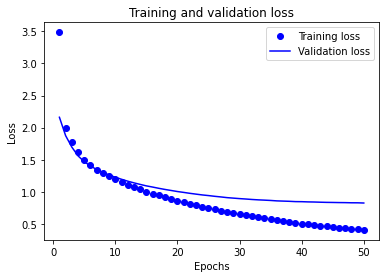

In [33]:
import matplotlib.pyplot as plt

acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

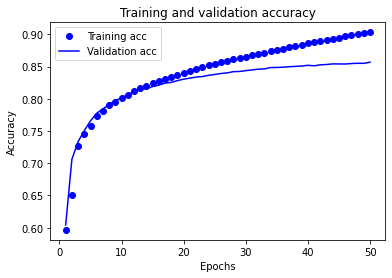

In [34]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## Step 4. 모델 구현하기 & 평가하기

In [35]:
# 테스트를 위해 모델 재설계

# 인코더
encoder_model = Model(inputs = encoder_inputs, outputs = encoder_states)

# 디코더
# 이전 시점의 상태를 보관할 텐서
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# 훈련 때 사용했던 임베딩 층을 재사용
dec_emb2= dec_emb_layer(decoder_inputs)

# 다음 단어 예측을 위해 이전 시점의 상태를 현 시점의 초기 상태로 사용
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]

# 모든 시점에 대해서 단어 예측
decoder_outputs2 = decoder_dense(decoder_outputs2)

# 수정된 디코더
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs2] + decoder_states2)

In [36]:
def decode_sequence(input_seq):
  # 입력으로부터 인코더의 마지막 시점의 상태(은닉 상태, 셀 상태)를 얻음
  states_value = encoder_model.predict(input_seq)

  # <SOS>에 해당하는 정수 생성
  target_seq = np.zeros((1,1))
  target_seq[0, 0] = tar_to_index['<start>']

  stop_condition = False
  decoded_sentence = ''

  # stop_condition이 True가 될 때까지 루프 반복
  # 구현의 간소화를 위해서 이 함수는 배치 크기를 1로 가정합니다.
  while not stop_condition:
    # 이점 시점의 상태 states_value를 현 시점의 초기 상태로 사용
    output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

    # 예측 결과를 단어로 변환
    sampled_token_index = np.argmax(output_tokens[0, -1, :])
    sampled_char = index_to_tar[sampled_token_index]

    # 현재 시점의 예측 단어를 예측 문장에 추가
    decoded_sentence += ' '+sampled_char

    # <eos>에 도달하거나 정해진 길이를 넘으면 중단.
    if (sampled_char == '<end>' or
        len(decoded_sentence) > 50):
        stop_condition = True

    # 현재 시점의 예측 결과를 다음 시점의 입력으로 사용하기 위해 저장
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = sampled_token_index

    # 현재 시점의 상태를 다음 시점의 상태로 사용하기 위해 저장
    states_value = [h, c]

  return decoded_sentence

- 결과확인

In [37]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq_to_src(input_seq):
  sentence = ''
  for encoded_word in input_seq:
    if(encoded_word != 0):
      sentence = sentence + index_to_src[encoded_word] + ' '
  return sentence

# 번역문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq_to_tar(input_seq):
  sentence = ''
  for encoded_word in input_seq:
    if(encoded_word != 0 and encoded_word != tar_to_index['<start>'] and encoded_word != tar_to_index['<end>']):
      sentence = sentence + index_to_tar[encoded_word] + ' '
  return sentence

- 훈련 데이터에 랜덤한 인덱스의 샘플의 결과를 출력

In [38]:
for seq_index in [3, 50, 100, 300, 1001]:
  input_seq = encoder_input_train[seq_index: seq_index + 1]
  decoded_sentence = decode_sequence(input_seq)

  print("입력문장 :",seq_to_src(encoder_input_train[seq_index]))
  print("정답문장 :",seq_to_tar(decoder_input_train[seq_index]))
  print("번역문장 :",decoded_sentence[1:-5])
  print("\n")

입력문장 : ['i', 'lied', '.'] 
정답문장 : ['j', 'ai', 'menti', '.'] 
번역문장 : ['j', 'ai', 't', 'occup', '.'] 


입력문장 : ['you', 'look', 'nervous', '.'] 
정답문장 : ['vous', 'avez', 'l', 'air', 'nerveux', '.'] 
번역문장 : ['vous', 'avez', 'l', 'air', 'nerveuses', '.'] 


입력문장 : ['hurry', 'up', 'girls', '.'] 
정답문장 : ['d', 'p', 'chez', 'vous', 'les', 'filles', '!'] 
번역문장 : ['d', 'p', 'chez', 'vous', 'les', 'filles', '!'] 


입력문장 : ['tom', 'never', 'lied', '.'] 
정답문장 : ['tom', 'n', 'a', 'jamais', 'menti', '.'] 
번역문장 : ['tom', 'n', 'a', 'jamais', 'fait', '.'] 


입력문장 : ['my', 'life', 'is', 'boring', '.'] 
정답문장 : ['ma', 'vie', 'est', 'ennuyeuse', '.'] 
번역문장 : ['ma', 'vie', 'est', 'finie', '.'] 




- 테스트 데이터에 랜덤한 인덱스의 샘플의 결과를 출력

## 회고
(1) 결과  
- 번역기 만들기는 seq2seq를 이용하여 영어-프랑스어번역기를 만들어 보았고 영어와 프랑스어의 내용이 유사함을 보였다.
- seq2seq 모델 훈련결과를 그래프로 출력해보고, validation loss그래프가 우하향하는 경향성을 보이며 학습이 진행되었다. 
- train loss와 validation loss 사이의 gap이 많이 일어나지 않은 모습도 확인 할 수 있었다.

(2)과정  
step 1. 정제, 정규화, 전처리(영어, 프랑스어 모두) & 디코더의 문장에 시작토큰, 종료 토큰 넣기  
step2. 케라스의 토크나이저로 텍스트를 숫자로 바꾸기  
step3. 임베딩 층(Embedding layer) 사용하기    
step4. 모델 구현하기 & 평가하기  

(3)애먹었던 부분
- 처음 프랑스어의 악센트를 삭제하지 않아서 악센트가 달린 철자는 삭제되는 현상이 나타났었다.
- latent_dim를 처음에 50으로 놓고 실행을 했을 때 번역이 정확하지 않은 것 같아 latent_dim를 64로 바꾸고 hidden_units를 64로 추가해서 실행을 해보니 전보다는 좋은 결과를 얻을 수 있었다.
- 처음 optimizer="rmsprop" 이렇게 되어있는 상태였는데 다른분들이 하신 걸 보니 "adam"
으로 되어 있어 바꾸었다. 그리고 무엇이 다른지 알아보았다.
  - RMSprop: 학습이 진행됨에 따라 parameter사이 차별화는 유지하되 학습속도가 지속적으로 줄어들어 0에 수렴하는 것은 방지 할 수 있게 된다. 학습의 최소 step은 유지할 수 있다
  - adam :RMSProp와 Momentum 기법을 합친 optimizer이다. Momentum에서 관성계수 m과 함께 계산된 Vt​로 parameter를 업데이트하지만 Adam에서는 기울기 값과 기울기의 제곱값의 지수이동평균을 활용하여 step변화량을 조절한다.

(4) 개념 정리
> ## seq2seq
 - seq2seq는 입력으로 word2vec과 같은 Word Embedding방법을 통하여 얻은 embedding을 Encoder에서 입력으로 받는다 
 - 각 단어에 해당하는 embedding은 벡터 형태로 dense representation을 가진다.
 - Encoder에서 각 단어의 embedding과 RNN의 hidden state를 거쳐서 정보가 압축이 되고 Encoder의 마지막 부분의 출력이 context vector가 된다. 
 - 즉, Encoder의 최종 목적은 context vector를 만드는 것에 있습니다. context vector는 간단하게 float로 이루어진 하나의 벡터이다. 벡터의 크기는 모델을 처음 설정할 때 원하는 값으로 설정할 수 있으며 256, 512, 1024와 같은 숫자를 많이 사용한다.
- Decoder에서는 context를 입력으로 받습니다. 먼저 Decoder의 첫 부분은 context와 문장의 처음을 표시하는 SOS(Start of Sequence)를 입력으로 받는다.
- RNN을 거쳤을 때, hidden state는 계속 다음 step으로 연결된다. (Decoder의 RNN → RNN) 
- 그리고 Dense - Sofmax를 거쳐서 y_0을 출력한다. 다음 y0은 다시 RNN의 입력으로 들어가게 된다. 즉, Decoder의 RNN은 yi와 hidden sate를 입력으로 받아서 yi+1을 생성한다. 
- 지금 까지 설명한 내용이 seq2seq 모델의 가장 기본적인 형태이다. 

> ## Encoder와 Decoder
- 문자 그대로 인코더는 입력 데이터를 인코딩(부호화)하고, 디코더는 인코딩 된 데이터를 디코딩(복호화)한다. 즉, 인코더는 입력을 처리하고 디코더는 결과를 생성한다
- 인코더는 문장을 가지고 Context 벡터를 만들어주는데, 이 Context 벡터에는 문장에 대한 정보가 응축되어 있다
- 디코더는 정보가 응축되어 있는 Context 벡터로부터 다른 문장을 생성해줍니다
- RNN으로 구성되어 있다

> ## hidden state  
- Encoder의 hidden state는 (Key, Value)로 사용된다
- Decoder의 hidden state는 Query로 사용된다



- seq2seq 구조

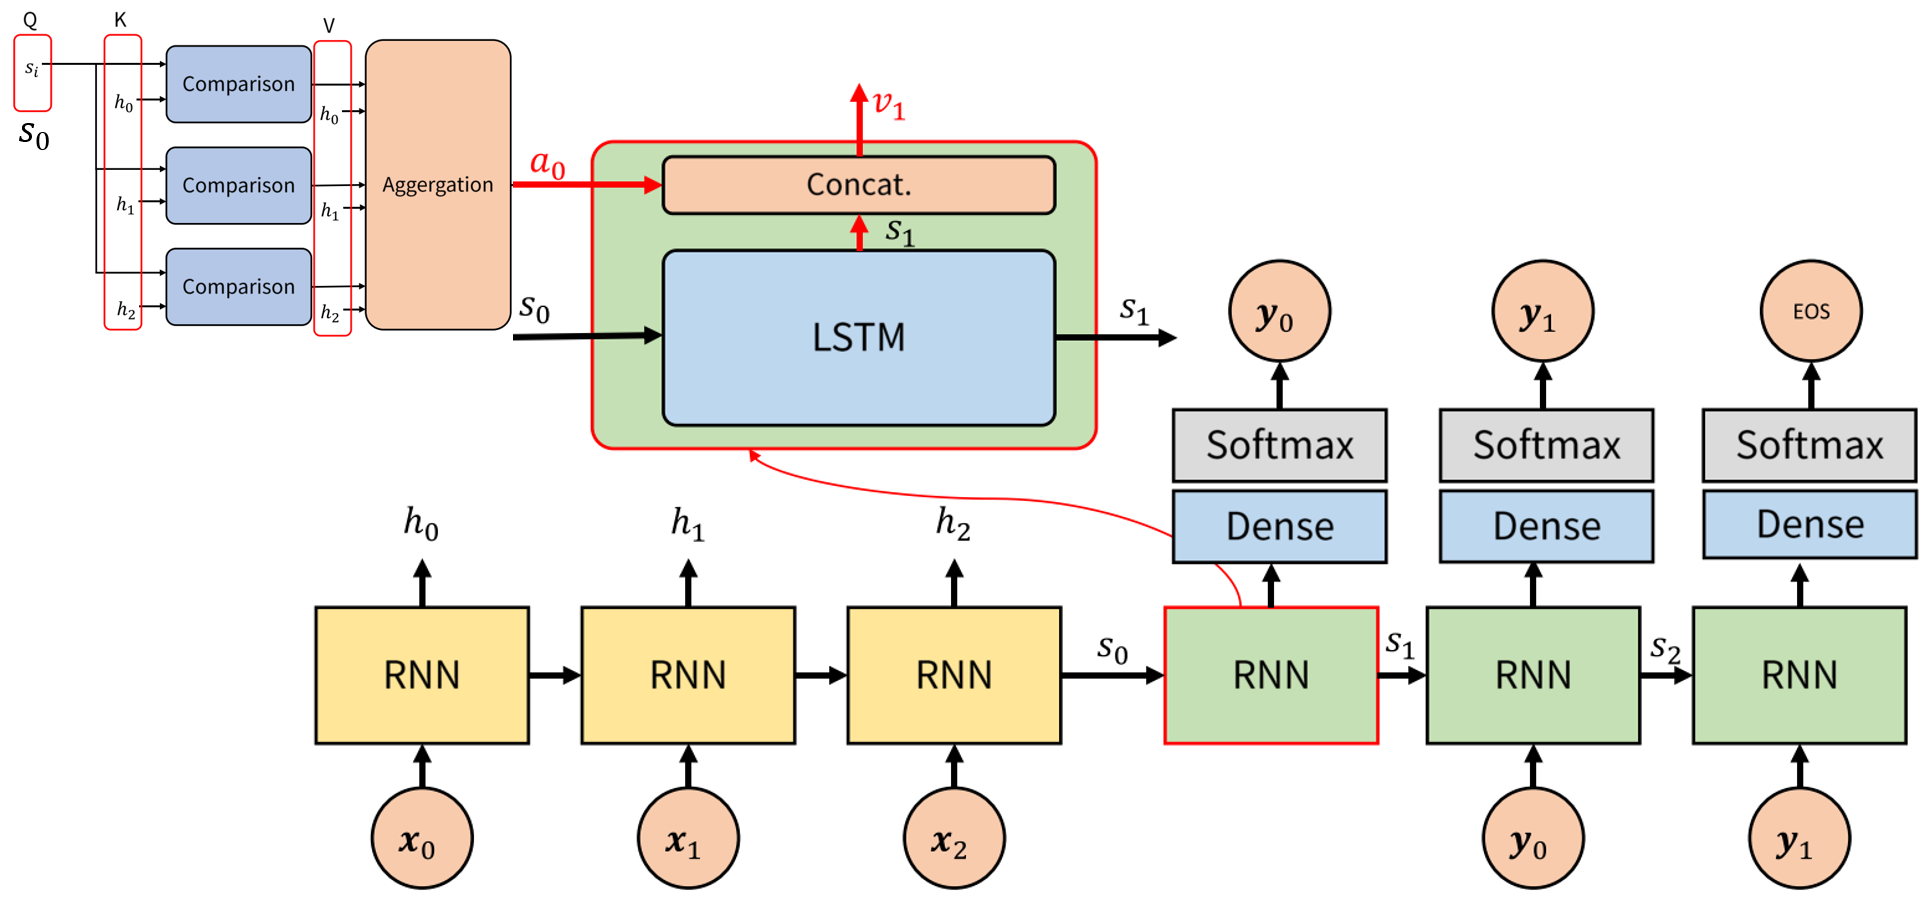

- optimizer 종류

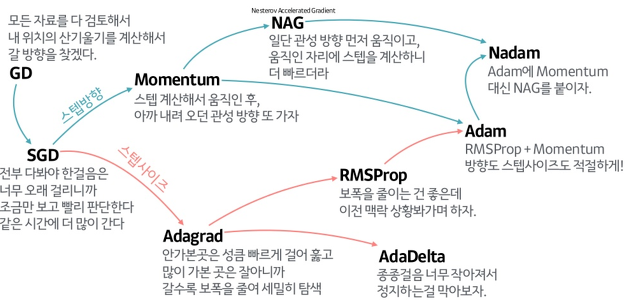

## Reference:   
  - https://gaussian37.github.io/dl-concept-attention/  
  - https://github.com/JaeHeee/AIFFEL_Project/blob/master/EXPLORATION/EXPLORATION%2015.%20%EB%B2%88%EC%97%AD%EA%B8%B0%EB%A5%BC%20%EB%A7%8C%EB%93%A4%EC%96%B4%EB%B3%B4%EC%9E%90.ipynb
  - https://mangastorytelling.tistory.com/entry/%EB%94%A5%EB%9F%AC%EB%8B%9D%EC%9D%84%EC%9D%B4%EC%9A%A9%ED%95%9C-%EC%9E%90%EC%97%B0%EC%96%B4-%EC%B2%98%EB%A6%AC-%EC%9E%85%EB%AC%B8-1502-Word-Level-%EB%B2%88%EC%97%AD%EA%B8%B0-%EB%A7%8C%EB%93%A4%EA%B8%B0Neural-Machine-Translation-seq2seq-Tutorial
  - https://onevision.tistory.com/entry/Optimizer-의-종류와-특성-Momentum-RMSProp-Adam [312 개인 메모장:티스토리]